以下の人を想定。
- 納税者本人: 障害なし、勤労学生ではない
- 配偶者: なし
- 扶養家族: なし
- 被保険者種別: 第2号被保険者
- 給与: 0〜1,500,000円（10万区切りで計算）
- 賞与: なし
- 申告年: 令和6年をベースに定額減税をなしにした設定

社会保険
- 介護保険: 負担あり（40歳以上）
- 事業所所在地: 東京都
- 月額が88,000円未満の場合は加入なし

住民税
- 合計所得金額が一定金額（45万円）以下の場合は免除

In [1]:
import os
import sys

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib_fontja

pd.set_option("display.max_rows", None)

sys.path.append(os.path.join(os.getcwd(), '..', 'lib'))

from const.所得税_基礎控除_R2 import 所得税_基礎控除_R2
from const.所得税_税率_H27 import 所得税_税率_H27
from const.給与所得控除_R2 import 給与所得控除_R2
from const.厚生年金保険_R2 import 厚生年金保険_R2
from const.健康保険_R6 import 健康保険_R6
from const.介護保険_R6 import 介護保険_R6
from const.雇用保険_R5 import 雇用保険_R5
from const.住民税_基礎控除_R3 import 住民税_基礎控除_R3
from const.住民税_税率一覧_R7 import 住民税_税率一覧_R7
from context import get_context, open_clone_context

from 所得.給与所得 import 給与, 給与所得者の特定支出に関する明細書
from 所得税及び復興特別所得税.申告内容確認表_第一表 import 所得税及び復興特別所得税の申告内容確認表_第一表, 所得金額等
from 社会保険 import 社会保険
from 住民税 import 住民税
from ふるさと納税 import ふるさと納税上限額
from 納税者 import 納税者

In [2]:
"""
設定項目 年に対する定数
"""
# 2024年(R6)
context = get_context()
context.給与所得控除 = 給与所得控除_R2()
context.所得税_基礎控除 = 所得税_基礎控除_R2()
context.所得税_税率 = 所得税_税率_H27()
context.住民税_基礎控除 = 住民税_基礎控除_R3()
context.住民税_税率一覧 = 住民税_税率一覧_R7()
context.厚生年金保険 = 厚生年金保険_R2()
context.健康保険 = 健康保険_R6()
context.介護保険 = 介護保険_R6()
context.雇用保険 = 雇用保険_R5()

In [3]:
"""
設定項目 納税者情報
"""
# 年収のうち賞与が何ヶ月分か
# 賞与額によって標準報酬月額の区分が代わり社会保険料が変わる
# 賞与nヶ月分 = {7: 1, 12: 1}
賞与nヶ月分 = {}

# 納税者
# 年齢によって介護保険の有無が変わる
# 事業所所在地によって健康保険の保険料率が変わる
x納税者 = 納税者()
x納税者.納税者本人.年齢 = 40
x納税者.事業所所在地 = '東京都'

In [4]:
class 年間社会保険:
    def __init__(self, 納税者: 納税者, 給与等の収入金額: int, 賞与nヶ月分: dict[int,float]):
        """
        1年間に支払う社会保険の内訳

        args:
            納税者 (納税者): 納税者
            給与等の収入金額 (int): 月額12ヶ月分と賞与をあわせた額
            賞与nヶ月分 (dict[int,float]): 月に対する賞与、単位はヶ月分
        """
        self.納税者 = 納税者
        self.給与等の収入金額 = 給与等の収入金額
        self.賞与nヶ月分 = 賞与nヶ月分

        self.月ごとの月額と賞与 = self.年収を月額と賞与に分割()
        if self.月ごとの月額と賞与[1][0]>=88_000:
            # 社会保険に加入
            self.月ごとの社会保険 = {m: 社会保険(月額, 賞与額, x納税者) for m, (月額, 賞与額) in self.月ごとの月額と賞与.items()}
        else:
            # 社会保険に未加入
            self.月ごとの社会保険 = {}

    def 年収を月額と賞与に分割(self) -> dict[int,tuple[int,int]]:
        """
        年収から標準報酬月額と標準賞与額に分割する

        return:
            dict[int,tuple[int,int]:
                key (int): 月
                value (tuple[int,int]): 月額、賞与額
        """
        nヶ月分 = 12 + sum(self.賞与nヶ月分.values())
        月額 = round(self.給与等の収入金額 / nヶ月分)
        賞与 = {m: round(self.給与等の収入金額 / nヶ月分 * n) for m, n in self.賞与nヶ月分.items()}

        return {m: (月額, 賞与.get(m, 0)) for m in range(1, 13)}

    def 被保険者負担額(self) -> int:
        """
        1年間の被保険者負担額
        """
        return sum([x社会保険.被保険者負担額 for x社会保険 in self.月ごとの社会保険.values()])

    def 事業主負担額(self) -> int:
        """
        1年間の事業主負担額
        """
        return sum([x社会保険.事業主負担額 for x社会保険 in self.月ごとの社会保険.values()])

    def 社会保険内訳(self) -> pd.DataFrame:
        """
        1年間の内訳

        return:
            df (pd.DataFrame): columns=保険名、被保険者負担額、事業主負担額
        """
        社会保険一覧 = pd.DataFrame(columns=['保険名', '被保険者負担額', '事業主負担額'])
        for 月社会保険 in self.月ごとの社会保険.values():
            社会保険一覧 = pd.concat([社会保険一覧, 月社会保険.to_dataframe()], ignore_index=True)
        df = 社会保険一覧.groupby('保険名').agg('sum').reset_index()
        if len(df.index)>0:
            return df
        else:
            return pd.DataFrame(columns=['保険名', '被保険者負担額', '事業主負担額'])

    def 社会保険内訳flat(self) -> pd.DataFrame:
        """
        1年間の内訳

        return:
            df (pd.DataFrame): columns=label、value
        """
        社会保険合計 = self.社会保険内訳()
        if len(社会保険合計)>0:
            被保険者負担 = 社会保険合計[['保険名', '被保険者負担額']].rename(columns={'保険名': 'label', '被保険者負担額': 'value'})
            被保険者負担['label'] += ' (被保険者負担)'

            事業主負担 = 社会保険合計[['保険名', '事業主負担額']].rename(columns={'保険名': 'label', '事業主負担額': 'value'})
            事業主負担['label'] += ' (事業主負担)'

            return pd.concat([被保険者負担, 事業主負担], ignore_index=True)
        else:
            return pd.DataFrame({
                'label': ['介護保険 (被保険者負担)', '健康保険 (被保険者負担)', '厚生年金保険 (被保険者負担)', '雇用保険 (被保険者負担)', '介護保険 (事業主負担)', '健康保険 (事業主負担)', '厚生年金保険 (事業主負担)', '雇用保険 (事業主負担)'],
                'value': 0,
            })


In [5]:
def 年収内訳(x納税者: 納税者, 給与等の収入金額: int, 賞与nヶ月分: dict[int,float]) -> pd.Series:
    # 所得
    x給与 = 給与(給与等の収入金額)
    x給与所得者の特定支出に関する明細書 = 給与所得者の特定支出に関する明細書(x給与=x給与)
    x所得金額等 = 所得金額等(給与=x給与所得者の特定支出に関する明細書)

    # 社会保険料
    x年間社会保険 = 年間社会保険(x納税者, x給与.給与等の収入金額, 賞与nヶ月分)
    x納税者.社会保険料 = x年間社会保険.被保険者負担額()
    # 社会保険内訳_df = x年間社会保険.社会保険内訳flat()

    # 所得税
    x所得税及び復興特別所得税の申告内容確認表_第一表 = 所得税及び復興特別所得税の申告内容確認表_第一表(所得金額等=x所得金額等, 納税者=x納税者)
    所得税_i = x所得税及び復興特別所得税の申告内容確認表_第一表.所得税_税額控除.申告納税額

    # 住民税
    # 前年中の合計所得金額が一定金額以下の場合は免除
    # 扶養家族（同一生計対象配偶者または扶養親族）がいない場合は45万円
    if x所得金額等.合計所得金額>450_000:
        x住民税 = 住民税(所得税_所得控除=x所得税及び復興特別所得税の申告内容確認表_第一表.所得税_所得控除, 納税者=x納税者)
        住民税_i = x住民税.年税額
    else:
        住民税_i = 0

    # 手取り
    手取り_i = 給与等の収入金額 - x納税者.社会保険料 - 所得税_i - 住民税_i

    return pd.Series({
        '年収': 給与等の収入金額,
        # **dict(zip(社会保険内訳_df['label'], 社会保険内訳_df['value'])),
        '社会保険料 (被保険者負担)': x納税者.社会保険料,
        '社会保険料 (事業主負担)': x年間社会保険.事業主負担額(),
        '社会保険内訳': x年間社会保険.社会保険内訳(),
        '所得税': 所得税_i,
        '住民税': 住民税_i,
        '手取り': 手取り_i,
        'ふるさと納税上限額': ふるさと納税上限額(x所得金額等, x納税者),
    })

In [6]:
def 年収グラフデータ(年収range: range) -> tuple[pd.DataFrame, int]:
    年収内訳df = pd.DataFrame()
    ymax = 0
    for i in 年収range:
        ser = 年収内訳(x納税者, i, 賞与nヶ月分)
        年収内訳df = pd.concat([年収内訳df, pd.DataFrame([ser])], ignore_index=True)
        ymax = max(ymax, ser['年収'] + ser['社会保険料 (事業主負担)'])
    return (年収内訳df, ymax)

In [7]:
"""
国民民主党案
"""
from meta.住民税 import I住民税_基礎控除
from meta.所得税 import I所得税_基礎控除
from utils import get_range_dict_value, intfloor

class 所得税_基礎控除_国民民主党案(I所得税_基礎控除):
    __所得税_基礎控除の定義: dict[range,int] = {
        # 2,400万円以下
        range(-sys.maxsize,  24_000_001): 1_230_000,
        # 2,400万円超2,450万円以下
        range(  24_000_001,  24_500_001): 1_070_000,
        # 2,450万円超2,500万円以下
        range(  24_500_001,  25_000_001): 910_000,
        # 2,500万円超
        range(  25_000_001, sys.maxsize): 750_000,
    }

    def 所得税_基礎控除(self, 所得金額等_合計: int) -> int:
        return get_range_dict_value(self.__所得税_基礎控除の定義, 所得金額等_合計)

class 住民税_基礎控除_国民民主党案(I住民税_基礎控除):
    __住民税_基礎控除の定義: dict[range,int] = {
        # 2,400万円以下
        range(-sys.maxsize,  24_000_001): 1_180_000,
        # 2,400万円超2,450万円以下
        range(  24_000_001,  24_500_001): 1_040_000,
        # 2,450万円超2,500万円以下
        range(  24_500_001,  25_000_001): 900_000,
        # 2,500万円超
        range(  25_000_001, sys.maxsize): 750_000,
    }

    def 住民税_基礎控除(self, 合計所得金額: int) -> int:
        return get_range_dict_value(self.__住民税_基礎控除の定義, 合計所得金額)

In [8]:
"""
自民党案
"""
from meta.所得税 import I所得税_基礎控除
from meta.給与所得控除 import I給与所得控除, 給与所得控除後の金額Protocol
from utils import get_range_dict_value, intfloor

class 所得税_基礎控除_自民党案(I所得税_基礎控除):
    __所得税_基礎控除の定義: dict[range,int] = {
        # 2,400万円以下
        range(-sys.maxsize,  24_000_001): 580_000,
        # 2,400万円超2,450万円以下
        range(  24_000_001,  24_500_001): 420_000,
        # 2,450万円超2,500万円以下
        range(  24_500_001,  25_000_001): 260_000,
        # 2,500万円超
        range(  25_000_001, sys.maxsize): 100_000,
    }

    def 所得税_基礎控除(self, 所得金額等_合計: int) -> int:
        return get_range_dict_value(self.__所得税_基礎控除の定義, 所得金額等_合計)


class 給与所得控除_自民党案(I給与所得控除):
    __給与所得控除の定義: dict[range,給与所得控除後の金額Protocol] = {
        # ～650,999円
        range(-sys.maxsize,     651_000): lambda a: 0,
        # 651,000円～1,899,999円
        range(     651_000,   1_900_000): lambda a: a - 650_000,
        # 1,900,000円～3,599,999円
        range(   1_900_000,   3_600_000): lambda a: round(intfloor(a/4, 3) * 2.8 - 80_000),
        # 3,600,000円～6,599,999円
        range(   3_600_000,   6_600_000): lambda a: round(intfloor(a/4, 3) * 3.2 - 440_000),
        # 6,600,000円～8,499,999円
        range(   6_600_000,   8_500_000): lambda a: round(a * 0.9 - 1_100_000),
        # 8,500,000円～
        range(   8_500_000, sys.maxsize): lambda a: a - 1_950_000,
    }

    def 給与所得控除後の金額の式(self, 給与等の収入金額: int) -> 給与所得控除後の金額Protocol:
        return get_range_dict_value(self.__給与所得控除の定義, 給与等の収入金額)

In [9]:
年収range = range(0, 15_000_001, 100_000)

# 現行
現行_年収内訳df, ymax = 年収グラフデータ(年収range)

# 国民民主党案
with open_clone_context() as context:
    context.所得税_基礎控除 = 所得税_基礎控除_国民民主党案()
    context.住民税_基礎控除 = 住民税_基礎控除_国民民主党案()
    国民民主党案_年収内訳df, ymax = 年収グラフデータ(年収range)

# 自民党案
with open_clone_context() as context:
    context.所得税_基礎控除 = 所得税_基礎控除_自民党案()
    context.給与所得控除 = 給与所得控除_自民党案()
    自民党案_年収内訳df, ymax = 年収グラフデータ(年収range)

In [10]:
df = pd.DataFrame()
df['年収'] = 現行_年収内訳df['年収']
df['現行税額'] = 現行_年収内訳df['年収'] - 現行_年収内訳df['手取り']

df['自民党案_減税額'] = 自民党案_年収内訳df['手取り'] - 現行_年収内訳df['手取り']
df['国民民主党案_減税額'] = 国民民主党案_年収内訳df['手取り'] - 現行_年収内訳df['手取り']

df['自民党案_税額'] = df['現行税額'] - df['自民党案_減税額']
df['国民民主党案_税額'] = df['現行税額'] - df['国民民主党案_減税額']

df['自民党案_減税率'] = df['自民党案_減税額'] / df['現行税額']
df['国民民主党案_減税率'] = df['国民民主党案_減税額'] / df['現行税額']

df[['年収', '自民党案_減税額', '国民民主党案_減税額']][df['年収'].isin([2_000_000, 3_000_000, 5_000_000, 6_000_000, 8_000_000, 10_000_000])]

,年収,自民党案_減税額,国民民主党案_減税額
20,2000000,10100,81300
30,3000000,10100,113300
50,5000000,10200,131900
60,6000000,10200,151600
80,8000000,20400,228100
100,10000000,20500,228200


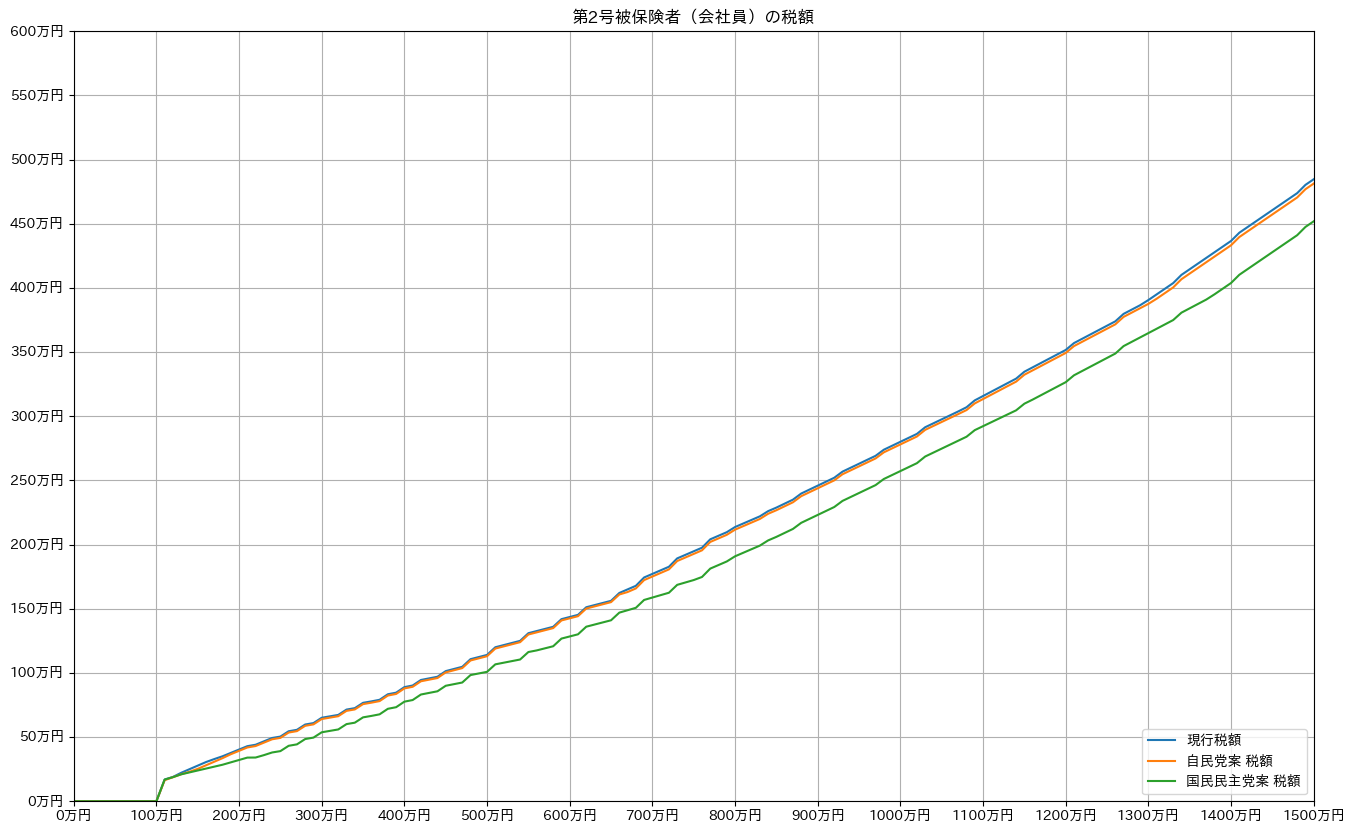

In [11]:
xticks_indexes = range(年収range.start, 年収range.stop, 1_000_000)
xticks_labels = list(map(lambda x: f'{round(x/10_000)}万円', xticks_indexes))

yticks_indexes = range(年収range.start, 年収range.stop, 500_000)
yticks_labels = list(map(lambda x: f'{round(x/10_000)}万円', yticks_indexes))

plt.figure(figsize=(16, 10), facecolor='#ffffff')
plt.title('第2号被保険者（会社員）の税額')
plt.plot(df['年収'], df['現行税額'], label='現行税額')
plt.plot(df['年収'], df['自民党案_税額'], label='自民党案 税額')
plt.plot(df['年収'], df['国民民主党案_税額'], label='国民民主党案 税額')
plt.xticks(xticks_indexes, xticks_labels)
plt.yticks(yticks_indexes, yticks_labels)
plt.xlim(年収range.start, 年収range.stop)
plt.ylim(0, 6_000_000)
plt.legend(loc='lower right')
plt.grid()
plt.show()

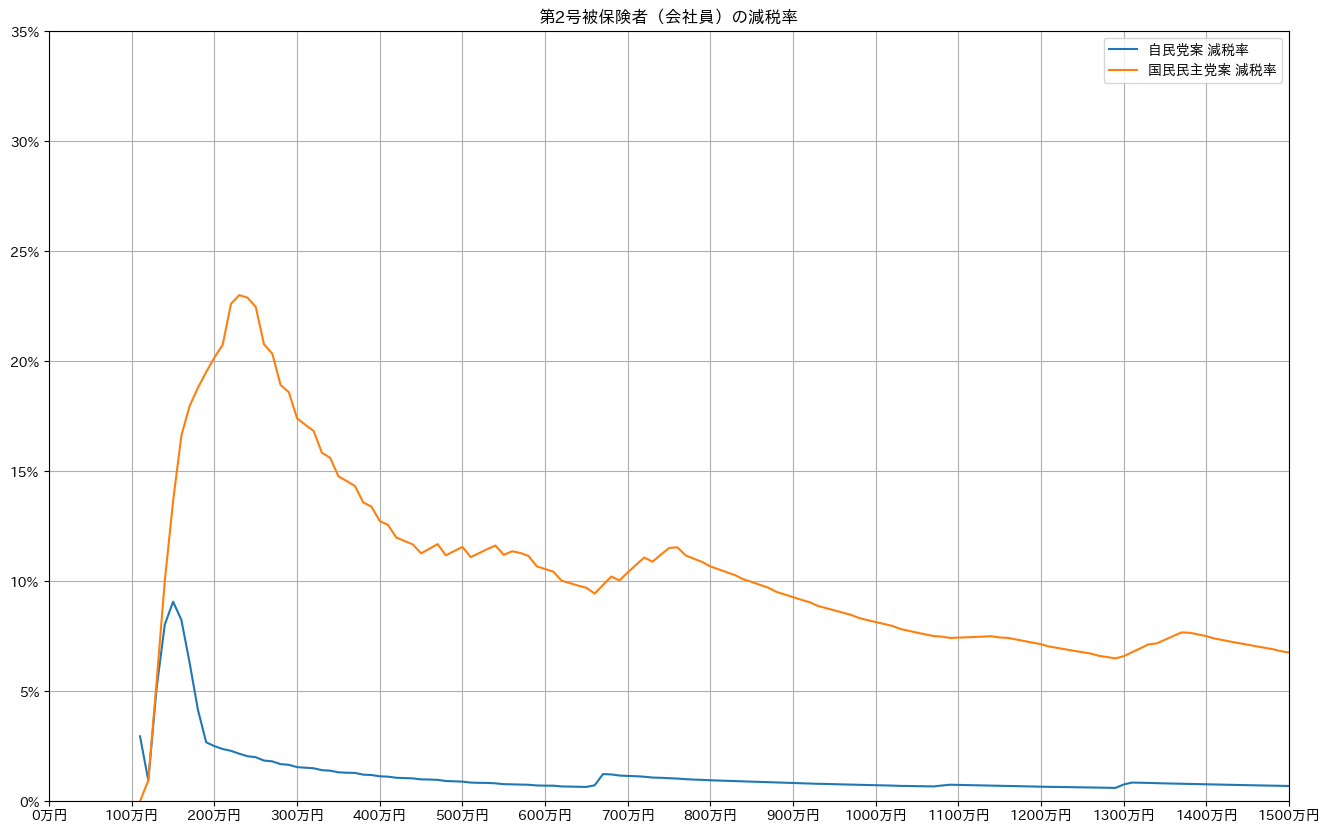

In [12]:
xticks_indexes = range(年収range.start, 年収range.stop, 1_000_000)
xticks_labels = list(map(lambda x: f'{round(x/10_000)}万円', xticks_indexes))

yticks_indexes = range(0, 101, 5)
yticks_labels = list(map(lambda x: f'{x}%', yticks_indexes))

plt.figure(figsize=(16, 10), facecolor='#ffffff')
plt.title('第2号被保険者（会社員）の減税率')
plt.plot(df['年収'], df['自民党案_減税率']*100, label='自民党案 減税率')
plt.plot(df['年収'], df['国民民主党案_減税率']*100, label='国民民主党案 減税率')
plt.xticks(xticks_indexes, xticks_labels)
plt.yticks(yticks_indexes, yticks_labels)
plt.xlim(年収range.start, 年収range.stop)
plt.ylim(0, 35)
plt.legend(loc='upper right')
plt.grid()
plt.show()